# Algorithms in Structural Biology
## Assignment 2 
### Part 2
##### Andrinopoulou Christina (ds2200013)

This part of the assignment takes into consideration 50 Ca atoms of SARS-COV-2 Spike glycoprotein (PDB id:7NEH). These Ca atoms are located in chain E at the residues 401-450.

We create the Cayley-Menger matrix for these atoms and compute the corresponding rank. Then we perturb the entries of the aforementioned matrix and compute again the rank. Finally, we compute the 3D coordinates of the perturbed structures and calculate the cRMSD between these structures and the original one.

First of all, we import some packages that we are going to use. If you followed the instructions of the README and you activated the enviroment struc_bio the next cell will be executed without any problem, otherwise you should install the packages that are not installed in your PC.

In [1]:
import pandas as pd
import numpy as np
import math
import random
from Bio.PDB.PDBParser import PDBParser
parser = PDBParser(PERMISSIVE=1)
import warnings
from Bio.PDB.PDBExceptions import PDBConstructionWarning
warnings.simplefilter('ignore', PDBConstructionWarning)
%matplotlib inline
import matplotlib.pyplot as plt

## cRMSD
As we have already mentioned, we will need the cRMSD in the final step of this assignment.

The class *cRMSD* contains all the appropriate functions for the calculation of the cRMSD distance between two structures. This class was implemented for the first assignment of the course and we use it here with some modifications in the way that read the inputs.

Steps of algorithm:
- Find the centroid of each conformation 
- Move the conformations to the origin of the space: Subtract the centroids from each coordinate
- Singular Value Decomposition (SVD): best transformation Q for the conformation 
- Apply transformation to a conformation 
- Calculate the corresponding cRMSD distance

In [2]:
class cRMSD:
    def __init__(self, filename1, filename2):
        self.filename1 = filename1
        self.filename2 = filename2
        self.conformations, self.number_of_atoms = self.read_conformations()
        self.centroid_1 = []
        self.centroid_2 = []
        self.U = np.empty((3,3))
        self.Sigma = np.empty((0,3))
        self.VT = np.empty((3,3))
        self.Q = np.empty((3,3))
        
    
    # read the conformations from the txt file
    def read_conformations(self):     
        conformations_dict = dict()
        df1 = pd.read_csv(self.filename1, delimiter = "\t", header=None)
        df2 = pd.read_csv(self.filename2, delimiter = "\t", header=None)
        conformations_dict[0] = df1
        conformations_dict[1] = df2
        return conformations_dict, df1.shape[0]
        
        
    # calculate the centroid
    def find_centroid(self, conformation1, conformation2):
        sum_result1 = conformation1.sum(axis = 0)
        sum_result2 = conformation2.sum(axis = 0)
        self.centroid_1 = [sum_result1[i]/self.number_of_atoms for i in range(len(sum_result1))]
        self.centroid_2 = [sum_result2[i]/self.number_of_atoms for i in range(len(sum_result2))]
        
        
    # move the conformations to the origin
    def move_to_origin(self, conformation1, conformation2):
        number_of_cols = conformation1.shape[1]
        for i in range(number_of_cols):
            conformation1[i] -= self.centroid_1[i]
            conformation2[i] -= self.centroid_2[i]
        return conformation1, conformation2
        
       
    # find best tranformation of one conformation, using SVD
    def SVD_process(self, conformation1, conformation2):
        XT_Y = np.matmul(conformation1.T.to_numpy(), conformation2.to_numpy())
        self.U, self.Sigma, self.VT = np.linalg.svd(XT_Y)
        self.Q = np.matmul(self.U, self.VT)
        detQ = np.linalg.det(self.Q)
        if detQ < 0:
            self.U[2] = -self.U[2]
            self.Q = np.matmul(self.U, self.VT)        
        
    
    # calculate cRMSD
    def cRMSD_distance(self, conformation1, conformation2):
        temp = np.matmul(conformation1.to_numpy(), self.Q) - conformation2.to_numpy()
    
        sum_norms = 0
        for i in range(temp.shape[0]):
            sum_norms += pow(np.linalg.norm(temp[i]),2)
        return math.sqrt(sum_norms/self.number_of_atoms)
     
       
    # compare two conformations
    def compare(self, conformation1, conformation2, print_flag=False):
        self.find_centroid(conformation1, conformation2)
        conformation1, conformation2 = self.move_to_origin(conformation1, conformation2)
        self.SVD_process(conformation1, conformation2)
        c_rmsd = self.cRMSD_distance(conformation1, conformation2)
        if print_flag:
            print(f'cRMSD = {c_rmsd}')
        return c_rmsd
    
    
    def pipeline(self):
        self.read_conformations()
        self.compare(conformation1=self.conformations[0], conformation2=self.conformations[1], print_flag=True)

The function below saves the content of a dataframe into a file. We will use it for saving the 3D coordinates of the structures (original and perturbed) later on.

In [3]:
def write_atoms_at_csv(df, filename):            
    df.to_csv(filename, header=None, index=None, sep='\t')

The class *Cayley_Menger* contains all the functions for the calculation of the Cayley-Menger matrix, the calculation of the corresponding rank, the creation of the perturbed Cayley-Menger matrix and the computation of the 3D coordinates based on the distances.

**get_cat()**:
First of all, the class contains the function *get_ca* that reads a pdb file and get the Ca atoms that we mentioned before (E401-E450). For this function the parser from Bio.PDB is utilized. The coordinates of the Ca atoms are stored in the variable *ca_atoms* and the corresponding residues (that contain the Ca atoms) at the variable *residue_name* of the class.

**calculate_cayley_menger_matrix()**:
This function creates the distance matrix and then based on that it creates the Cayley-Menger matrix (or border matrix). The distance matrix M is a squared, symmetric with real entries and $M_{ii} = 0$. This is because this matrix contains the distance between two atoms. In our case, it contains the distance between two Ca atoms. Every term of the distance matrix is calculated based on the formula below:

\begin{align}
    M_{ij} = \frac{1}{2}dist(p_i, p_j)^{2}
\end{align}

where $p_i$ and $p_j$ the coordinates of the atom i and j. The Cayley-Menger matrix contains the distance matrix, but also contains on more row and one more column. If $M$ is the distance matrix, the Cayley-Menger matrix is given below:

\begin{pmatrix}{}
0   & 1 & 1 & ... & 1 \\
1   &   &   &     &   \\
... &   &   & M   &   \\
1   &   &   &     &  
\end{pmatrix}

In this function, we first create the distance matrix based on the aforementioned formula. It is important to mention that we do not traverse all the elements of the initialized matrix in order to assign the suitable value, but only the triangular, because we take advantage of the symmetry of the distance matrix. Then we add at the matrix one row and one column (with tha appropriate values) at the beginning so as to create the border matrix.

**compute_rank()**:
This function just calculates the rank of a matrix. Also, the function creates two important plots. The first one is a bar plot that shows the values of all the singular values and this helps the user to understand which are the singular values that are non-zero (or not near the zero) and as a result to confirm the rank that the function returns. The second plot is a bar-plot, as well. This plot shows the value of the fractions between two consecutive singular values. If the value of a fraction is extremely high, this means that the singular value of the denominator of this fraction is very close to zero and we assume that is zero and as a result the last non-zero singular value is this one that is present on the numerator. Therefore, this plot helps the user to confirm the rank value that was returned by the function. (Attention: we assume that the first singular value is indexed with 0 and the singular values are in descending order.)  

**pipeline()**:
The function *pipeline* calls all the functions for answering the first two questions of the Part 2. First of all, it extracts from the pdb file the atoms that we desire, then is creates the Cayley-Menger matrix for these atoms and finally it computes the rank of the matrix.

**perturb_of_matrix()**:
This function perturbs the entries of the Cayley-Menger matrix by a *percentage* that takes as input. For every entry in the up triangular Cayley-Menger matrix (apart from the first row and the first column of the matrix), the function perturbs the value in a random way. First of all, it selects the sign of the perturbation, which means that a value will be added of subtracted from the initial term. This value is a percentage of the initial one. If the final result is negative, we force the function to select the other sign so as to be positive the final result. The perturbation does not affect the symmetry of the matrix, because when we change the term $B_{ij}$, we also change the term $B_{ji}$ in the same way. Also, it is obvious that the matrix is positive again, because we handle the case that the random selection may deal to negative values, as we mentioned before. 

**compute_Gram_matrix()**:
This function computes the Gram matrix based on the Cayley-Menger matrix. The Gram matrix is a $n\times n$ matrix, where $n$ is the number of the atoms that we examined. The value of the term $G_{ij}$ is given by the formula:

\begin{align}
    G_{ij} = \frac{d_{i0}^2 - d{ij}^2 + d_{j0}^2}{2}
\end{align}

where $d_{ij}$ the distance between the atoms i and j and $d_{i0}$ the distance between the i atom and the first atom of the structure and $d_{j0}$ the distance between the j atom and the first atom of the structure. It is obvious that the term $\frac{d_{ij}^2}{2}$ is the term $B_{ij}$ of the Cayley-Menger matrix. Therefore, the construction of the Gram matrix in function *compute_Gram_matrix* is based on the Cayley-Menger matrix. 

**SVD()**:
This function return the matrices $U$ $\Sigma$ and $V^T$ from the Singular Value Decomposition.

**find_coordinates_pertub()**:
This function finds the 3D coordinates of a structure based on the corresponding distances. First of all, it creates the perturbed version of the Cayley-Menger matrix and calculates the corresponding rank. After that, it implements the steps of the embedding algorithm:
- It creates the Gram matrix based on the border matrix.
- It runs the SVD for the Gram matrix.
- It forces the rank of the Gram matrix to be equal to 3. For this purpose, it keeps only the first 3 singular values ($\Sigma '$).
- It returns the coordinates of the structure that are calculated based on the formula: $\sqrt{\Sigma '}V^T$

**get_params()**:
This function returns the important variables of the class. If the variable is a matrix, the function returns the matrix in the dataframe form.

In [4]:
class Cayley_Menger():
    def __init__(self, name, chain='E', start=401, end=450):
        self.name = name
        self.chain = chain
        self.start = start
        self.end = end
        self.ca_atoms = []
        self.residues_names = []
        self.rank = -1
        self.rank_pertub = -1
        self.perturbation = False
        
    def get_ca(self):
        structure = parser.get_structure(self.name, self.name+'.pdb')
        for model in structure:
            for chain in model:
                if chain.id == self.chain: # border
                    for residue in chain:
                        name = residue.get_resname() 
                        code = int(str(residue).split('=')[2].split(' ')[0])
                        if code >= self.start and code <= self.end: # borders
                            for atom in residue:
                                if atom.id == 'CA':
                                    coordinates = atom.get_coord()
                                    self.ca_atoms.append(coordinates)   
                                    self.residues_names.append(name)

    def calculate_cayley_menger_matrix(self):
        n = len(self.ca_atoms)
        self.cayley_menger_matrix = np.zeros((n, n)) # initialize matrix
        for i in range(len(self.ca_atoms)):
            for j in range(len(self.ca_atoms)):
                if i < j: # do not traverse all the matrix, because the matrix is symmteric
                    ca1 = self.ca_atoms[i]
                    ca2 = self.ca_atoms[j] 
                    dist = np.linalg.norm(ca1-ca2) # distance
                    matrix_value = pow(dist,2) * 0.5
                    self.cayley_menger_matrix[i][j] = matrix_value
                    self.cayley_menger_matrix[j][i] = matrix_value # symmetric
        # add the first row and the first column of the Cayley-Menger matrix
        first_column = [1.0]*n
        first_row = [0.0]
        first_row.extend([1.0]*n)
        self.cayley_menger_matrix = np.insert(self.cayley_menger_matrix, 0, np.array(first_column), axis=1)
        self.cayley_menger_matrix = np.insert(self.cayley_menger_matrix, 0, np.array(first_row), axis=0)

    def compute_rank(self, matrix):
        singular_values = np.linalg.svd(matrix)[1]
        previous_frac = 0
        fracs = []
        diffs = []
        for i in range(1, len(singular_values)):
            previous = singular_values[i-1]
            current = singular_values[i]
            frac = previous/current
            diff = frac - previous_frac
            fracs.append(frac)
            diffs.append(diff)
            previous_frac = frac
        ig, axes = plt.subplots(1, 2, figsize=(23,9))
        plt.subplot(121), plt.barh([i for i in range(len(singular_values))], singular_values), plt.title('Singular Values'), plt.xlabel('Value'), plt.ylabel('Singular value')
        plt.subplot(122), plt.barh([str(i-1)+'/'+str(i) for i in range(1, len(singular_values))], fracs)
        plt.title('Fractions of Singular Values'), plt.xlabel('Value'), plt.ylabel('Fraction of two consecutive singular value')
        plt.show()
        return np.linalg.matrix_rank(matrix.astype(np.float32))
    
    def pipeline(self):
        self.get_ca()
        self.calculate_cayley_menger_matrix()
        self.rank = self.compute_rank(self.cayley_menger_matrix)
        print(f'The rank of the Cayley-Menger matrix for the {self.name} is {self.rank}')
        
    def perturb_of_matrix(self, percentage):
        cayley_menger_matrix = self.cayley_menger_matrix # initial matrix
        cayley_menger_pertub = cayley_menger_matrix # perturbed matrix
        rows, cols = cayley_menger_matrix.shape
        for i in range(rows):
            for j in range(cols):
                if i < j: # do not traverse all the matrix, because the matrix is symmteric
                    if i == 0 or j == 0: # avoid first row and column
                        continue
                    sign = [-1,1][random.randrange(2)] # select a rangom sign (+/-)
                    new_value = cayley_menger_matrix[i][j] + sign*percentage*cayley_menger_matrix[i][j] # perturbation
                    if new_value < 0: # negative result
                        new_value = - new_value # take the opposite sign
                    cayley_menger_pertub[i][j] = new_value 
                    cayley_menger_pertub[j][i] = new_value # symmetric
        self.cayley_menger_pertub = cayley_menger_pertub # assign the result to the class variable
       
    def compute_Gram_matrix(self):
        n = len(self.ca_atoms)
        self.gram_matrix = np.zeros((n, n), dtype='float32')
        for i in range(1, n):
            for j in range(1, n):
                # the gram matrix is based on the cayley-menger matrix
                self.gram_matrix[i-1][j-1] = self.cayley_menger_matrix[i][1] - self.cayley_menger_matrix[i][j] + self.cayley_menger_matrix[j][1]
    
    def SVD(self, matrix):
        return np.linalg.svd(matrix)
        
    def find_coordinates_pertub(self, percentage):
        self.perturbation = True
        self.perturb_of_matrix(percentage)
        self.rank_pertub = self.compute_rank(self.cayley_menger_pertub)
        print(f'The rank of the perturbed Cayley-Menger matrix for the {self.name} is {self.rank_pertub}')
        self.compute_Gram_matrix()
        _, Sigma, Vt = self.SVD(self.gram_matrix)
        self.coordinates = np.matmul(np.diag(np.sqrt(Sigma)), Vt)
        self.coordinates = np.array(self.coordinates[:3].transpose())
        
    def get_params(self):
        names = [' ']
        names.extend(self.residues_names)
        df = pd.DataFrame(self.cayley_menger_matrix, columns=names, index=names)
        df_initial_ca = pd.DataFrame(np.array(self.ca_atoms))
        
        if self.perturbation:
            df_pertub = pd.DataFrame(self.cayley_menger_pertub, columns=names, index=names) 
            df_gram = pd.DataFrame(self.gram_matrix, columns=self.residues_names, index=self.residues_names)
            df_coordinates = pd.DataFrame(self.coordinates)
        else:
            df_pertub = []
            df_gram = []
            df_coordinates = []
        return {
            'cayley_menger_matrix': df,
            'rank': self.rank,
            'cayley_menger_matrix_pertub': df_pertub,
            'rank_pertub': self.rank_pertub,
            'gram_matrix': df_gram,
            'coordinates': df_coordinates,
            'initial_ca_atoms': df_initial_ca
        }
    

We create a Cayley-Menger object and we execute the function *pipeline* of the class that creates the Cayley-Menger matrix and calculates the rank of the matrix. The rank of the matrix is equal to 5, as we expected. For more details about that please check the report. As we can see in the first bar-plot, there are 5 singular values that are not zero or not near to the zero. Also, if we divide two consecutive singular values, we expect that the result of the division between a non-zero singular value and a zero singular value will be infinite. However, in this case the result is extremely high compared to the other ones because the singular values are not zero, but they are very close to zero. Therefore, these plotsw confirm that the rank of the matrix is equal to 5.

Also, we can check a part of the Cayley-Menger matrix.

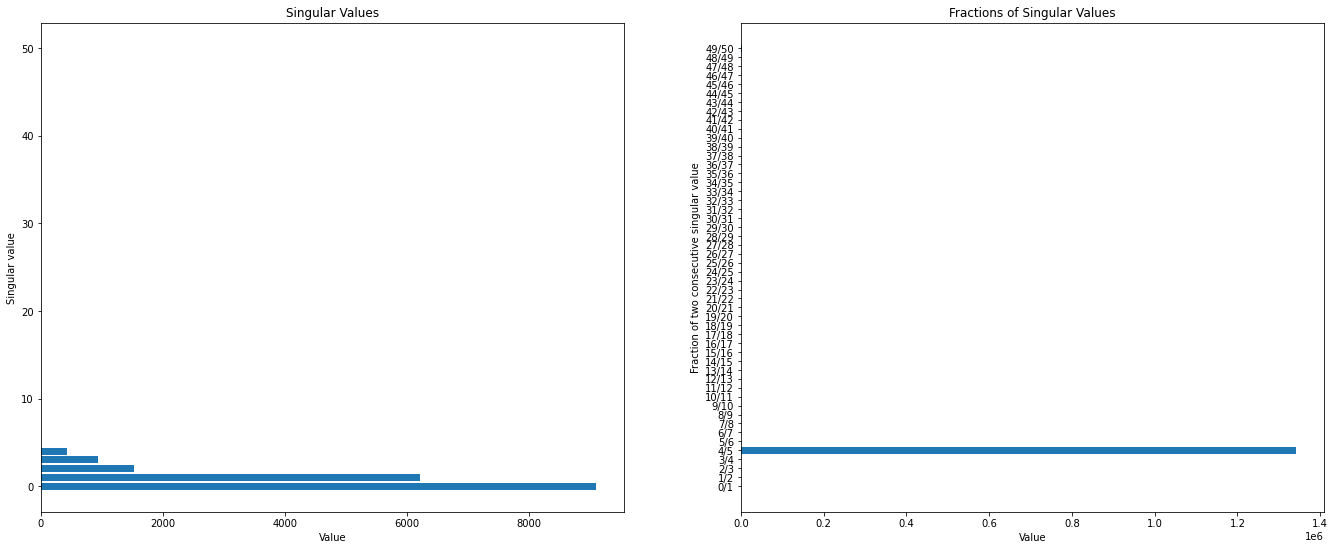

The rank of the Cayley-Menger matrix for the 7neh is 5
One part of the Cayley-Menger matrix (border matrix) is: 


VAL        ILE        ARG        GLY        ASP        GLU  \
     0.0   1.000000   1.000000   1.000000   1.000000   1.000000   1.000000   
VAL  1.0   0.000000   7.282306  25.376079  44.483113  70.144572  49.279283   
ILE  1.0   7.282306   0.000000   7.248473  22.270879  34.951606  20.484108   
ARG  1.0  25.376079   7.248473   0.000000   7.133696  14.444005  13.443128   
GLY  1.0  44.483113  22.270879   7.133696   0.000000   7.226499  14.650858   

           VAL        ARG        GLN  ...         LEU        ASP        SER  \
      1.000000   1.000000   1.000000  ...    1.000000   1.000000   1.000000   
VAL  44.994722  86.352437  79.651805  ...   61.646126  37.152725  61.577199   
ILE  24.520966  54.830465  49.600620  ...   86.314680  53.566219  68.723919   
ARG  22.987027  48.628426  52.746083  ...   92.013973  59.435031  62.378230   
GLY  16.402409  35.328880  52.149931  ...  101.761974  77.493756  80.175037   

            LYS         VAL         GLY         GLY         ASN         TYR  \
       1.000000    1.000000    1.000000    1.000000    1.000000    1.000000   
VAL  103.666166  157.632900  170.193557  110.993598   73.268855   74.757184   
ILE  115.227265  162.735750  166.873425  108.490461   80.599646   79.317460   
ARG  107.516735  143.580825  145.720739   96.387347   81.849071   86.995906   
GLY  132.613687  168.497679  179.412786  131.021252  119.319600  135.150512   

            ASN  
       1.000000  
VAL   55.470116  
ILE   71.344140  
ARG   92.007867  
GLY  141.944127  

[5 rows x 51 columns]

In [5]:
cayley_menger = Cayley_Menger(name='7neh')
cayley_menger.pipeline()
print('One part of the Cayley-Menger matrix (border matrix) is: ')
cayley_menger_df = cayley_menger.get_params()['cayley_menger_matrix']
cayley_menger_df.head()

We get the 3D coordinates of the structure using the function *get_params* of the class and we save the result at a csv file.

In [6]:
initial_ca = cayley_menger.get_params()['initial_ca_atoms']
write_atoms_at_csv(initial_ca, 'initial_7NEH.csv')

We perturb the entries of the Cayley-Menger matrix by $2\%$. For this purpose, we call the function *find_coordinates_pertub* of the *Cayley_Menger* class that perturbs the border matrix, computes the corresponding Gram matrix and contains the steps of the embedding algorithm for finding the 3D coordinates of the structure. Also, this function calculates the rank of the perturbed Cayley-Menger matrix.

We get the coordinates from the function *get_params* of the class and we save the result in a csv file. 

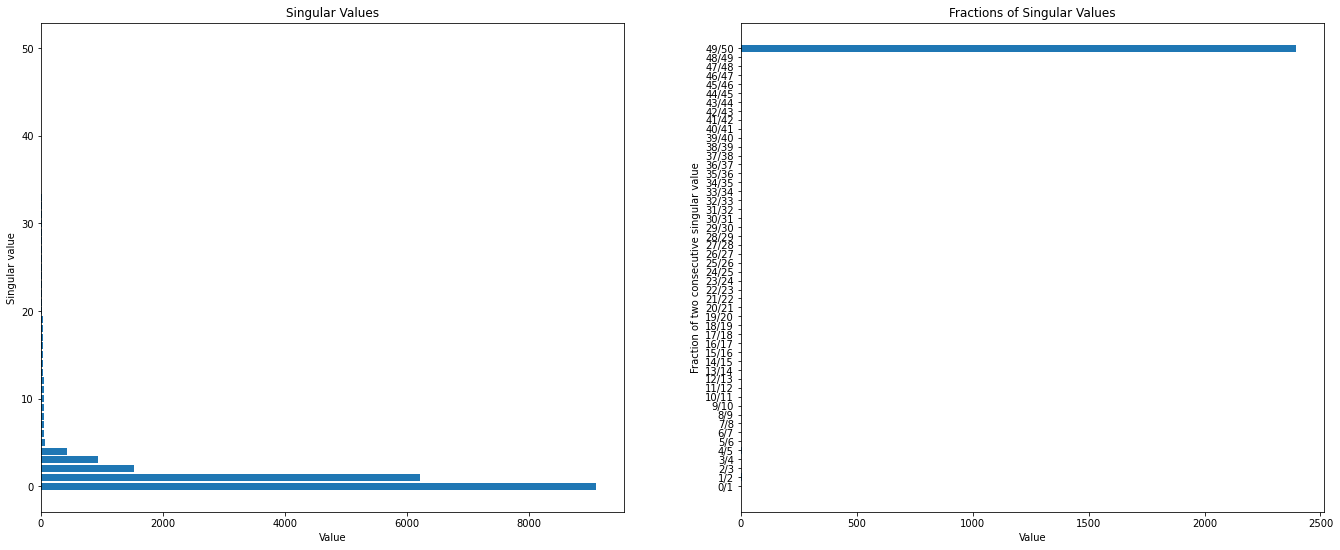

The rank of the perturbed Cayley-Menger matrix for the 7neh is 50


In [7]:
cayley_menger.find_coordinates_pertub(percentage=0.02)
coordinates2 = cayley_menger.get_params()['coordinates']
write_atoms_at_csv(coordinates2, 'perturbed_2_7NEH.csv')

Finally, we calculate the cRMSD distance between the original structure and the perturbed structure.

In [8]:
crmsd = cRMSD(filename1='initial_7NEH.csv', filename2='perturbed_2_7NEH.csv')
crmsd.pipeline()

cRMSD = 1.494024491011247


We follow the same procedure as before, but now the percentage of the perturbation is equal to $4\%$.

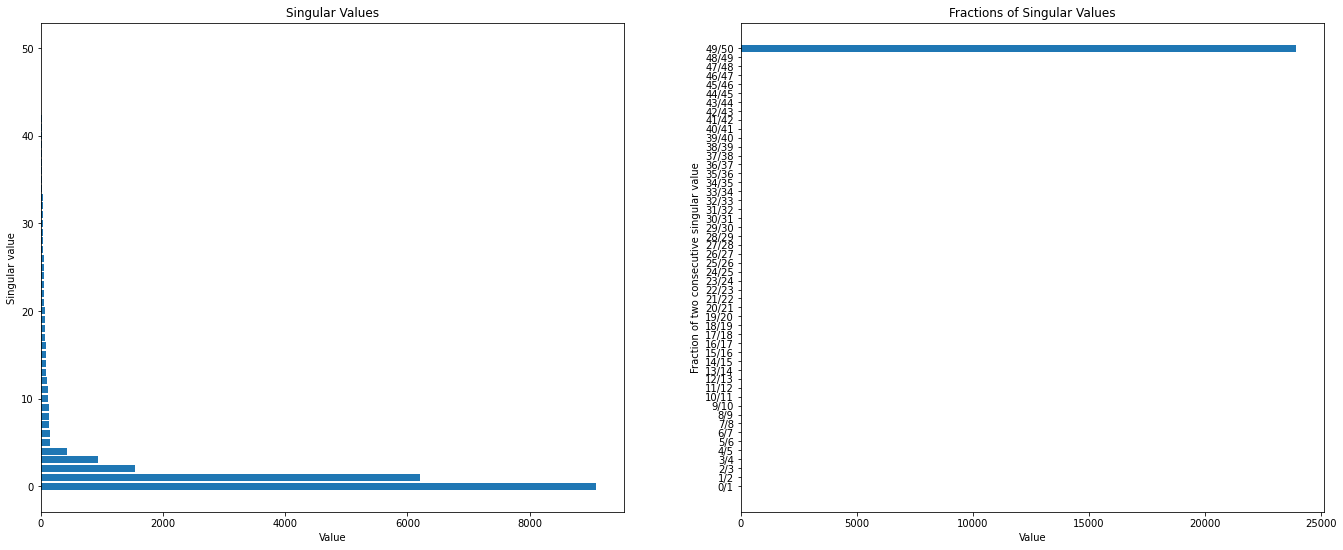

The rank of the perturbed Cayley-Menger matrix for the 7neh is 50


In [9]:
cayley_menger.find_coordinates_pertub(percentage=0.04)
coordinates4 = cayley_menger.get_params()['coordinates']
write_atoms_at_csv(coordinates4, 'perturbed_4_7NEH.csv')

In [10]:
crmsd = cRMSD(filename1='initial_7NEH.csv', filename2='perturbed_4_7NEH.csv')
crmsd.pipeline()

cRMSD = 1.665884145360435


In [11]:
# crmsd = cRMSD(filename1='perturbed_2_7NEH.csv', filename2='perturbed_4_7NEH.csv')
# crmsd.pipeline()